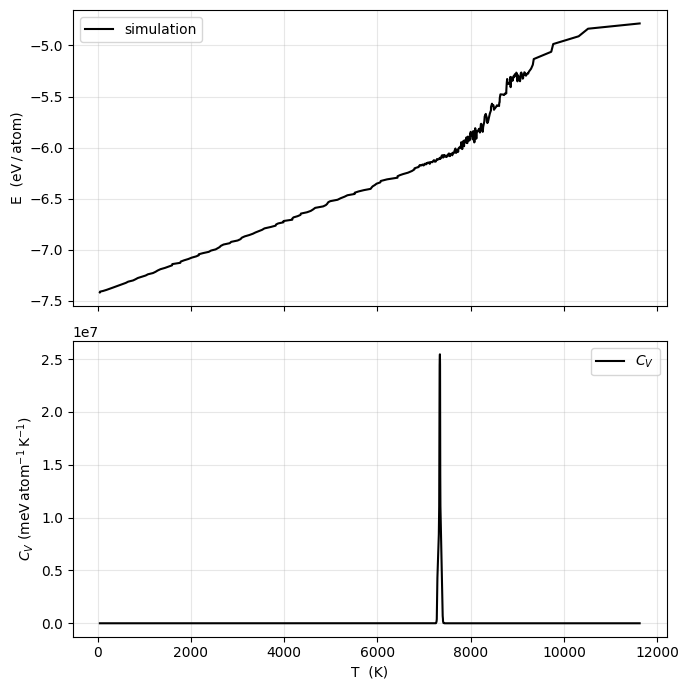

Specific‑heat peaks:
  T = 50.2 K   C_V = 0.25678 eV/atom/K   (prominence 0.24035)
  T = 50.6 K   C_V = 0.59397 eV/atom/K   (prominence 0.59481)
  T = 50.8 K   C_V = 0.32497 eV/atom/K   (prominence 0.23794)
  T = 5512.2 K   C_V = 0.05466 eV/atom/K   (prominence 0.05455)
  T = 6430.9 K   C_V = 0.04187 eV/atom/K   (prominence 0.04179)
  T = 7339.8 K   C_V = 161074982.08801 eV/atom/K   (prominence 161074982.41679)
  T = 7706.3 K   C_V = 0.02183 eV/atom/K   (prominence 0.02219)
  T = 7730.4 K   C_V = 0.26874 eV/atom/K   (prominence 0.27379)
  T = 7928.3 K   C_V = 0.02161 eV/atom/K   (prominence 0.03789)
  T = 7995.5 K   C_V = 0.03475 eV/atom/K   (prominence 0.04667)
  T = 8112.0 K   C_V = 0.18517 eV/atom/K   (prominence 0.18671)
  T = 8176.7 K   C_V = 0.02415 eV/atom/K   (prominence 0.02413)
  T = 8323.6 K   C_V = 0.32730 eV/atom/K   (prominence 0.32747)
  T = 8763.3 K   C_V = 0.04432 eV/atom/K   (prominence 0.04396)
  T = 8851.9 K   C_V = 1.67127 eV/atom/K   (prominence 1.68956)
  T = 885

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.spatial import cKDTree
from scipy.spatial import Voronoi
from scipy.optimize import curve_fit

# ---- user‑editable parameters --------------------------------------------
FNAME      = 'data/e_vs_t.txt'   # path to your text file
N_ATOMS    = 4300                # divide total energy by this
WINDOW_FR  = 0.1               # Savitzky–Golay window (fraction of data)
POLY_ORDER = 3                   # polynomial order for SG filter
PEAK_PROM  = 0.02                # min. peak “prominence” in C_V
# --------------------------------------------------------------------------
def load_e_vs_t(fname):
    """
    Return (T, E_per_atom) for the full 0→T_max heating curve:
      1) Read in time order
      2) Split at every ΔT<0 drop into monotonic-up segments
      3) Concatenate all the heating segments (in time order)
      4) For each T, pick the first-seen E (no averaging across passes)
      5) Return strictly increasing T, and E_per_atom
    """
    raw = np.loadtxt(fname, usecols=(1,2))
    T_all = raw[:,0]
    E_all = raw[:,1] / N_ATOMS

    # find drops and split into monotonic-up runs
    dT       = np.diff(T_all)
    drop_idxs = np.where(dT < 0)[0]
    segments = np.split(np.arange(len(T_all)), drop_idxs+1)

    # take all runs of length>1 (i.e. heating chunks)
    idxs = np.concatenate([seg for seg in segments if len(seg)>1])
    T_sel = T_all[idxs]
    E_sel = E_all[idxs]

    # now pick the first E for each unique T
    Tuniq, first_idx = np.unique(T_sel, return_index=True)
    Euniq           = E_sel[first_idx]

    return Tuniq, Euniq




# 1. load & preprocess
T, E = load_e_vs_t(FNAME)

# 2. Savitzky–Golay smoothing of energy
n = len(E)
win = max(5, 2*int(n * WINDOW_FR // 2) + 1)      # odd, ≥5
E_smooth = savgol_filter(E, window_length=win, polyorder=POLY_ORDER)

# 3. C_V by finite difference on the smoothed curve
Cv = np.gradient(E_smooth, T)

# 4. peak detection
peaks, props = find_peaks(Cv, prominence=PEAK_PROM)

# 5. quick plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
ax1.plot(T, gaussian_filter1d(E,sigma=1.5), ms=2, label='simulation', c="k")
ax1.set_ylabel('E  (eV / atom)')
ax1.legend();  ax1.grid(alpha=0.3)

ax2.plot(T, gaussian_filter1d(Cv, sigma=5), label=r'$C_V$', c="k")
ax2.set_xlabel('T  (K)');  ax2.set_ylabel(r'$C_V$ (meV atom$^{-1}$ K$^{-1}$)')
ax2.legend();  ax2.grid(alpha=0.3)
fig.tight_layout();plt.show()

# 6. peak report
if len(peaks) == 0:
    print("No C_V peaks above the chosen prominence threshold.")
else:
    print("Specific‑heat peaks:")
    for p, prom in zip(peaks, props['prominences']):
        print(f"  T = {T[p]:.1f} K   C_V = {Cv[p]:.5f} eV/atom/K   (prominence {prom:.5f})")


In [20]:
np.set_printoptions(suppress=True, precision=3)
kB = 8.617*10e-5

raw = np.loadtxt("data/e_vs_t.txt")

pe_50 = np.mean(raw[:,-1][0:25])
T_50 = np.mean(raw[:,1][0:25])

Gamma_50 = pe_50/(kB*T_50)
Gamma_50

-171.28311434448332

In [21]:
pe_7000 = np.mean(raw[:,-1][125:145])
T_7000 = np.mean(raw[:,1][125:145])

Gamma_7000 = pe_7000/(kB*T_7000)
np.abs(Gamma_7000)

1.1244005665249734

In [22]:
pe_7500 = np.mean(raw[:,-1][225:245])
T_7500 = np.mean(raw[:,1][225:245])

Gamma_7500 = pe_7500/(kB*T_7500)
print(T_7500)
np.abs(Gamma_7500)

7449.013966536349


1.0490917460782063

In [23]:
pe_8000 = np.mean(raw[:,-1][345:445])
T_8000 = np.mean(raw[:,1][345:445])
print(T_8000)

Gamma_8000 = pe_8000/(kB*T_8000)
np.abs(Gamma_8000)

7921.3464224569725


0.9746122245761861

In [ ]:
pe_8000 = np.mean(raw[:,-1][345:445])
T_8000 = np.mean(raw[:,1][345:445])
print(T_8000)

Gamma_8000 = pe_8000/(kB*T_8000)
np.abs(Gamma_8000)